In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-y629tw87
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-y629tw87
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265176 sha256=99eb21a0c7dd0eee13a961067f5582d77d29d18431388637a6086ed827205368
  Stored in directory: /tmp/pip-ephem-wheel-cache-p53yui_z/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2022-11-20 03:06:40--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.2MB/s    in 5.4s    

2022-11-20 03:06:47 (9.41 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-11-20 03:06:47--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-11-20 03:06:47--
Total wall clock time: 6.4s
Downloaded: 1 files, 51M in 5.4s (9.41 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

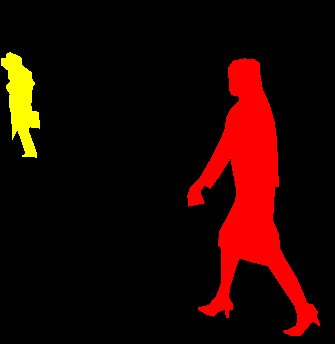

In [ ]:
from PIL import Image
mask = Image.open('PennFudanPed/PedMasks/FudanPed00005_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

Let's define the `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


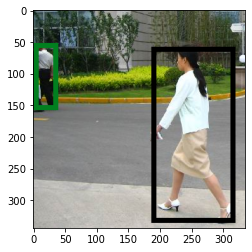

In [ ]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

dataset = PennFudanDataset('PennFudanPed/')

#Transforms
from torchvision import transforms as T
tf_ = T.ToTensor() # We only need this
transformed = tf_(dataset[4][0])
int_img = torch.tensor(transformed * 255, dtype = torch.uint8)

bounding_boxes_img = draw_bounding_boxes(int_img,dataset[4][1]['boxes'],width=8)

plt.imshow(bounding_boxes_img.permute(1, 2, 0))

Faster R-CNN model Definition


In [ ]:
import torchvision

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    return model

There are a bunch of helper functions in the pytorch vision repo lets grab those


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 251876, done.
remote: Counting objects: 100% (4555/4555), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 251876 (delta 4248), reused 4452 (delta 4179), pack-reused 247321
Receiving objects: 100% (251876/251876), 509.71 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (229151/229151), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


Lets Instantiate those helper functions

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

We now have the dataset class, the models and the data transforms. Let's instantiate them and create a train/test split


In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's Instantiate the model and SGD Optimizer

In [ ]:
device = torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:05:39  lr: 0.000090  loss: 0.3258 (0.3258)  loss_classifier: 0.1013 (0.1013)  loss_box_reg: 0.1396 (0.1396)  loss_objectness: 0.0687 (0.0687)  loss_rpn_box_reg: 0.0162 (0.0162)  time: 5.6546  data: 0.2464  max mem: 0
Epoch: [0]  [10/60]  eta: 0:04:16  lr: 0.000936  loss: 0.3044 (0.3090)  loss_classifier: 0.1513 (0.1436)  loss_box_reg: 0.1069 (0.1054)  loss_objectness: 0.0422 (0.0470)  loss_rpn_box_reg: 0.0070 (0.0130)  time: 5.1262  data: 0.0292  max mem: 0
Epoch: [0]  [20/60]  eta: 0:03:10  lr: 0.001783  loss: 0.2862 (0.3086)  loss_classifier: 0.1404 (0.1412)  loss_box_reg: 0.1069 (0.1164)  loss_objectness: 0.0355 (0.0374)  loss_rpn_box_reg: 0.0102 (0.0136)  time: 4.7061  data: 0.0072  max mem: 0
Epoch: [0]  [30/60]  eta: 0:02:15  lr: 0.002629  loss: 0.2743 (0.2840)  loss_classifier: 0.1060 (0.1247)  loss_box_reg: 0.1052 (0.1145)  loss_objectness: 0.0125 (0.0320)  loss_rpn_box_reg: 0.0103 (0.0128)  time: 4.1860  data: 0.0069  max mem: 0
Epoch: [0]  [40/60] 

# Results

## Faster R-CNN

Lets see the Results for the Faster RCNN with mobile-net model

In [ ]:
evaluate(model, data_loader_test, device=device)
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:45  model_time: 0.7701 (0.7701)  evaluator_time: 0.0013 (0.0013)  time: 0.9197  data: 0.1478  max mem: 0
Test:  [49/50]  eta: 0:00:00  model_time: 0.6148 (0.6775)  evaluator_time: 0.0009 (0.0013)  time: 0.6497  data: 0.0039  max mem: 0
Test: Total time: 0:00:34 (0.6881 s / it)
Averaged stats: model_time: 0.6148 (0.6775)  evaluator_time: 0.0009 (0.0013)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:

# Discussion

## DETR-ResNet50

From the results provided above, the DETR-ResNet50 can easily identify people in the images with relatively short time using the pretrained weights, however we see some false positives as mentioned earlier as well as some missing. It should be noted that this model struggled to detect people hidden behind the foreground which may prove as a shortcoming to deal with the problem statement.

## Fast R-CNN mobilenet

Lets load up an image

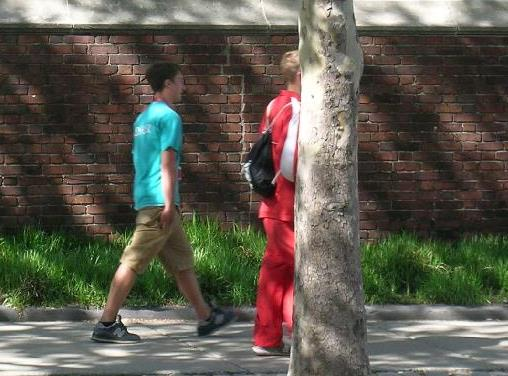

In [ ]:
img_test = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

img_test


And then we can see the bounding boxes based on the models prediction of the image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


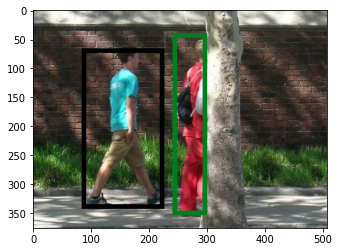

In [ ]:
tf_ = T.ToTensor() # We only need this
transformed = tf_(img_test)
int_img = torch.tensor(transformed * 255, dtype = torch.uint8)# bounding box

first_out = prediction[0]

score_threshold = 0.7

bounding_boxes_img = draw_bounding_boxes(int_img, first_out['boxes'][first_out['scores'] > score_threshold], width=8)

plt.imshow(bounding_boxes_img.permute(1, 2, 0)) # convert image to matplotlib compatible

Overall it seems like the results we gathered were succesfull and bounding boxes were received after training.